In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from pathlib import Path
import datetime
import mtnleaderreport
from dateutil.relativedelta import relativedelta

/Users/unger/dev/src/mountaineersdata/env/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
class FileCols(object):
	# Class holds information about a file.
	def __init__(self, allCols, dateCols, intCols, dropCols):
		self.allCols = allCols
		self.dateCols = dateCols
		self.intCols = intCols
		self.dropCols = dropCols

	@property 
	def colTypeMap(self):
		tm = {}
		for n in self.allCols:
			if not n in self.dateCols:
				if n in self.intCols:
					tm[n] = int
				else:
					tm[n] = str
		return tm

	@property
	def fixnaCols(self):
		# A list of columns where empty values should be changed to empty string
		return [ n for n in self.allCols if n not in self.dropCols and n not in self.dateCols ]

DataDirectory = Path(Path.home(), "Documents/mountaineers/kayak-seattle/data/paddleractivity")


#
# Column names.
#
C_FIRSTNAME = "First Name"
C_LASTNAME = "Last Name"
C_GRADUATIONDATE = "Graduation Date"
C_FULLNAME = "Full Name"
C_ACTIVITYTYPE = "Activity Type"
C_ACTIVITYSTARTDATE = "Activity Start Date"
C_ACTIVITYENDDATE = "Activity End Date"
C_ACTIVITYRESULT = "Activity Result"
C_ACTIVITYPARTICIPANTRESULT = "Activity Participant Result"
C_ACTIVITYCATEGORY = "Activity Category"
C_PADDLERTYPE = "Paddler Type"
C_TRIPCOUNT = "Trip Count"
C_COURSEPOSITION = "Course Position"
C_ENGAGEDYEARS = "Engaged Years"
C_GRADYEAR = "Grad Year"

PT_BASIC = "Basic"
PT_EQUIVALENCY = "Equivalency"

# Course positions that represent graduation.
COURSEPOSITION_LIST = ["Graduate", "Equivalent"]

# Sea kayaking activity type.
AT_SEAKAYAKING = "Sea Kayaking"


COLOR_BASIC = "xkcd:ocean blue"
COLOR_EQUIVALENT = "xkcd:pale orange"


# Define contents of our two data files
# Roster contains a roster of graduated students.
RosterFile = FileCols([ C_FIRSTNAME, C_LASTNAME, "Email", "Registration Status", C_COURSEPOSITION, C_GRADUATIONDATE ],
								[ C_GRADUATIONDATE] , [], [C_GRADUATIONDATE])
# Activity contains a list of graduate's subsequent activities
ActivityFile = FileCols([ C_FIRSTNAME, C_LASTNAME, "Email", "Course Title", "Activity Title", C_ACTIVITYCATEGORY, C_ACTIVITYTYPE, C_ACTIVITYSTARTDATE, C_ACTIVITYENDDATE, C_ACTIVITYRESULT, "Activity Participant Registration Status", C_ACTIVITYPARTICIPANTRESULT ],
								[C_ACTIVITYSTARTDATE, C_ACTIVITYENDDATE], [], [ C_ACTIVITYRESULT, C_ACTIVITYPARTICIPANTRESULT])

EquivRosterFileBase = "Seattle Equivalency"
EquivActivityFileBase = "Seattle Equivalency Activity"
EquivDates = [ 2015, 2016, 2021 ]

BasicRosterFileBase = "Seattle Basic"
BasicActivityFileBase = "Seattle Basic Activity"
BasicDates = [ 2015, 2016, 2017, 2018, 2019, 2021 ]

FirstYear = min(min(EquivDates),min(BasicDates))

# Types of activities we count.  Exclude field trips, lectures, and seminars. 
ActivityCategoryList = [ "Trip", "Clinic", "Field trip" ]

# Cute but not useful:  plt.xkcd()



In [3]:
def LoadData (dataDirectory, rosterFileBase, rosterCols: FileCols, activityFileBase, activityCols: FileCols, paddlerType, dateList, activityCategoryList):
	# Load a data set
	# dataDirectory:  Directory containing file names.
	# rosterFileBase:  Base for the roster file name. eg. "Seattle Basic"
	# rosterCols:  Information on the roster file.
	# activityFileBase:  Base for the activity file name.  eg "Seattle Basic Activity"
	# activityCols:  Informatoin on the activity file contents.
	# paddlerType:  Value to be added in the Paddler Type column.
	# dateList:  List of years to load.  Used to construct the complete file names
	# activityCategoryList:  Retain only activities with category in this list.append
	#
	# Reads a set of roster and activity files to build roster and activity across multiple years.
	# files should be named by roster and activity file base names plus a year and ".csv".  For example:
	#   "Seattle Basic 2017.csv" goes with "Seattle Basic Activity 2017.csv"
	#
	roster = None
	activity = None
	for date in dateList:
		#
		# Load the roster
		#
		fileName = f"{rosterFileBase} {date}.csv"
		filePath = Path(dataDirectory, fileName)
		ctm = rosterCols.colTypeMap
		r = pd.read_csv(filePath, usecols=rosterCols.allCols, parse_dates=rosterCols.dateCols, dtype=ctm)
		# Drop people who did not graduate
		r = r[r[C_COURSEPOSITION].isin(COURSEPOSITION_LIST)]

		# Fix columns that should contain empty string, not NaN and drop rows that still have NaN
		for n in rosterCols.fixnaCols:
			r[n].fillna('')
		r.dropna(inplace=True)

		if roster is None:
			roster = r
		else:
			roster = roster.append(r)


		#
		# Load the activity report
		#
		fileName = f"{activityFileBase} {date}.csv"
		filePath = Path(dataDirectory, fileName)
		a = pd.read_csv(filePath, usecols=activityCols.allCols, parse_dates=activityCols.dateCols, dtype=activityCols.colTypeMap)

		# Fix columns that should contain empty string, not NaN and drop rows that still have NaN
		for n in activityCols.fixnaCols:
			a[n].fillna('')
		a.dropna(inplace=True)

		# Limit to Sea Kayaking and specific activity category
		a = a[ (a[C_ACTIVITYTYPE] == AT_SEAKAYAKING) ]
		a = a[ a[C_ACTIVITYCATEGORY].isin(activityCategoryList) ]
		if activity is None:
			activity = a
		else:
			activity = activity.append(a)

	# Set paddler type and full name field for easier cross reference.
	roster[C_PADDLERTYPE] = paddlerType
	roster[C_FULLNAME] = roster[C_FIRSTNAME] + " " + roster[C_LASTNAME]
	activity[C_FULLNAME] = activity[C_FIRSTNAME] + " " + activity[C_LASTNAME]

	# Use full name as index.  	
	roster.set_index(C_FULLNAME, inplace=True)
	activity.set_index(C_FULLNAME, inplace=True)

	return (roster, activity)

(basicRoster, basicActivity) = LoadData(DataDirectory, BasicRosterFileBase, RosterFile, BasicActivityFileBase, ActivityFile, PT_BASIC, BasicDates, ActivityCategoryList)
(equivRoster, equivActivity) = LoadData(DataDirectory, EquivRosterFileBase, RosterFile, EquivActivityFileBase, ActivityFile, PT_EQUIVALENCY, EquivDates, ActivityCategoryList)
fullRoster = basicRoster.append(equivRoster)
fullActivity = basicActivity.append(equivActivity)

# Filter out trips that are before our earliest start date
# There are a few of these in the database, left over from previous import.  Some may appear for people who were active
# then renegnaged through equivlency
ed = pd.Timestamp(year=FirstYear, month=1, day=1)
fullActivity = fullActivity.loc[fullActivity[C_ACTIVITYSTARTDATE] >= ed]



# Add calculated columns

In [4]:
# Calculate trip counts for entries on roster
# Apply a lambda function on reach row.  
#   fullActivity.index == row.name
# returns an array of True, False for index matching name.  sum() calculates sum of those, counting True as 1 and False a 0

fullRoster[C_TRIPCOUNT] = fullRoster.apply(lambda row : sum(fullActivity.index == row.name), axis=1)

# Add grad year for easier grouping.
fullRoster[C_GRADYEAR] = fullRoster.apply(lambda row : row[C_GRADUATIONDATE].year, axis=1)

In [5]:
#
# Calculate the number of years someone has been engaged.
#
def calculateEngagedYears(row, activity):
	r = 0.0
	if row.name in activity.index:
		# If there are multiple activies, we get a series but if only one then we get a single Timestamp
		s = activity.loc[row.name, C_ACTIVITYSTARTDATE]
		if isinstance(s, pd.Timestamp):
			days = 1
		else:
			days = (s.max() - s.min()).days
		r = days / 365.0
	return r
fullRoster[C_ENGAGEDYEARS] = fullRoster.apply(lambda row : calculateEngagedYears(row, fullActivity), axis=1)

# Plot Number of Trips

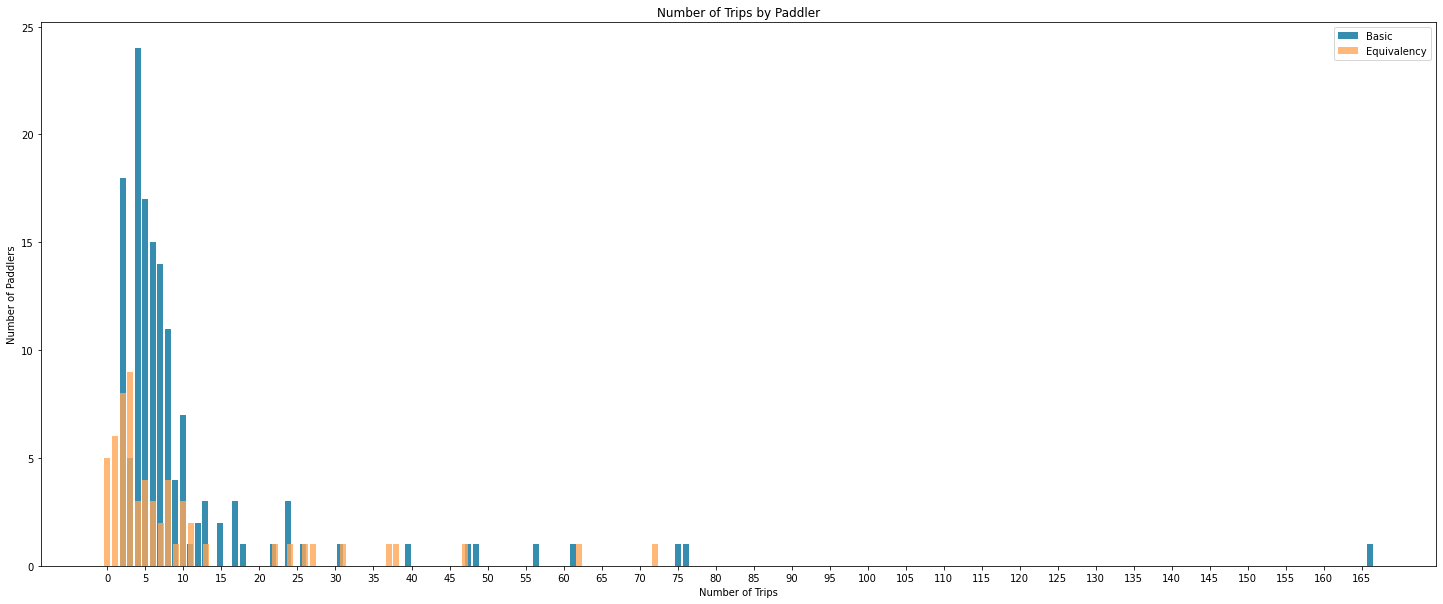

In [6]:

# Get trip count series for basic and equivalency paddlers
btc = fullRoster[fullRoster[C_PADDLERTYPE] == PT_BASIC][C_TRIPCOUNT]
etc = fullRoster[fullRoster[C_PADDLERTYPE] == PT_EQUIVALENCY][C_TRIPCOUNT]

b = max(btc.max(), etc.max())

# Graph the two
plt.figure(figsize=(25,10))
plt.hist(btc, bins=btc.max(), alpha=0.8, label=PT_BASIC, align='left', rwidth=0.8, color=COLOR_BASIC)
plt.hist(etc, bins=etc.max(), alpha=0.8, label=PT_EQUIVALENCY, align='left', rwidth=0.8, color=COLOR_EQUIVALENT)
plt.xlabel("Number of Trips")
plt.xticks(range(0,b,5))
plt.ylabel("Number of Paddlers")
plt.legend()
plt.title("Number of Trips by Paddler")
plt.savefig("Paddler Number of Trips.jpg")


# Plot Years of Engagement 

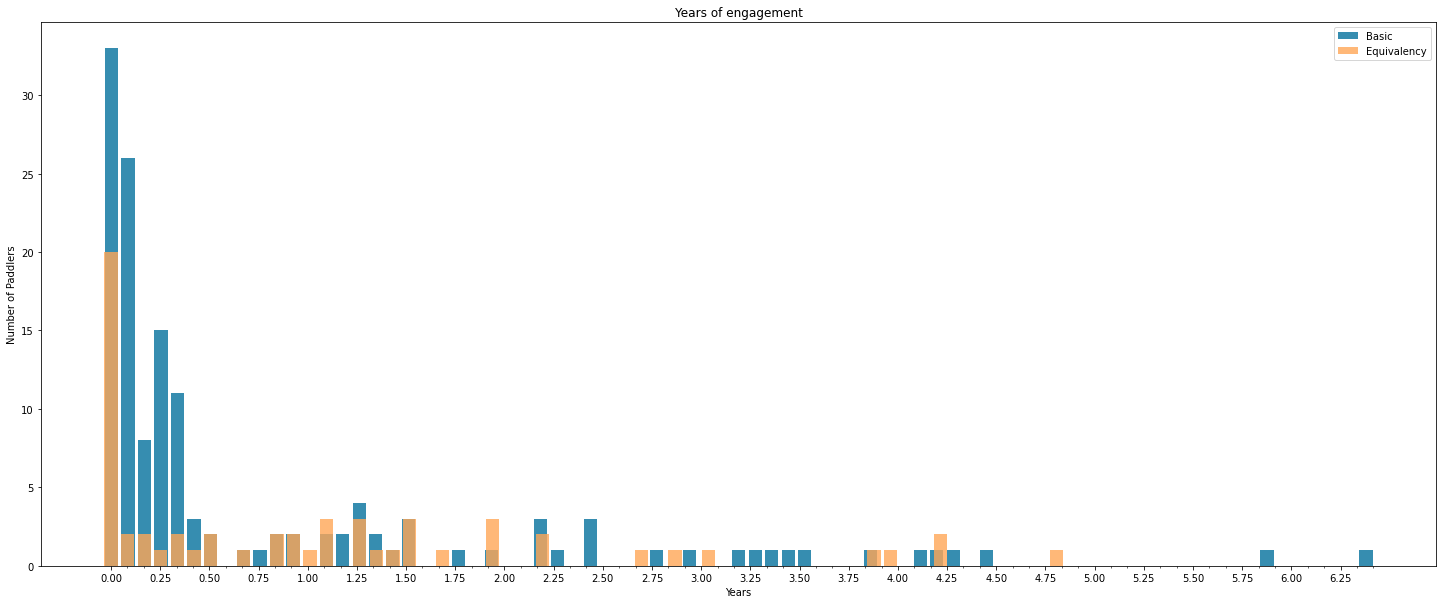

In [7]:

# Get years of engagement series for basic and equivalency paddlers
bye = fullRoster[fullRoster[C_PADDLERTYPE] == PT_BASIC][C_ENGAGEDYEARS]
eye = fullRoster[fullRoster[C_PADDLERTYPE] == PT_EQUIVALENCY][C_ENGAGEDYEARS]

maxYears = max(bye.max(), eye.max())
b = int(maxYears * 12)

# Graph the two

fig = plt.figure(figsize=(25,10))
plt.hist(bye, bins=int(bye.max()*12), alpha=0.8, label=PT_BASIC, align='left', rwidth=0.8, color=COLOR_BASIC)
plt.hist(eye, bins=int(eye.max()*12), alpha=0.8, label=PT_EQUIVALENCY, align='left', rwidth=0.8, color=COLOR_EQUIVALENT)
ax = fig.get_axes()[0]
plt.xlabel("Years")
ax.set_xticks(np.arange(0,maxYears,1.0/12.0), minor=True)
ax.set_xticks(np.arange(0,maxYears,0.25), minor=False)
plt.ylabel("Number of Paddlers")
plt.legend()
plt.title("Years of engagement")
plt.savefig("Paddler Number of Years.jpg")


# Plot Number of Graduates by Year

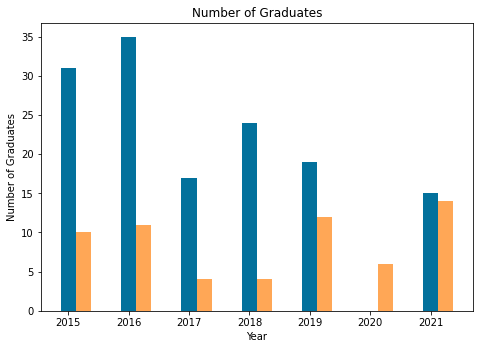

In [8]:
# Group by paddler type and grad year
# this givs us a two level grouping.  yg[PT_BASIC] is a series with index of years and value of number of graduates
#  yg[PT_BASIC].index and yg[PT_BASIC].values
yg = fullRoster.groupby([C_PADDLERTYPE, C_GRADYEAR]).size()

# But there may be missing years (2020 no basic class).  To display both on one graph we need
# to align the data.  Do this by creating a new data frame with a column for basic and equivlency.
# Then fill NaN with zero graduates.
yd = pd.DataFrame({PT_BASIC: yg[PT_BASIC], PT_EQUIVALENCY: yg[PT_EQUIVALENCY]})
yd.fillna(0, inplace=True)

# Now we have a dataframe with number of graduates each year.

# X is positions of our bars 
X = np.arange(len(yd))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title("Number of Graduates")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Graduates")
ax.bar(X, yd[PT_BASIC].values, tick_label=yd.index, width = 0.25, label=PT_BASIC, color=COLOR_BASIC)
ax.bar(X + 0.25, yd[PT_EQUIVALENCY].values,  width = 0.25, label=PT_EQUIVALENCY, color=COLOR_EQUIVALENT)
plt.savefig("Paddler Graduates by Year.jpg")

# Plot all basic and equivalency paddler activity

Saving 'Paddler Activity.jpg'


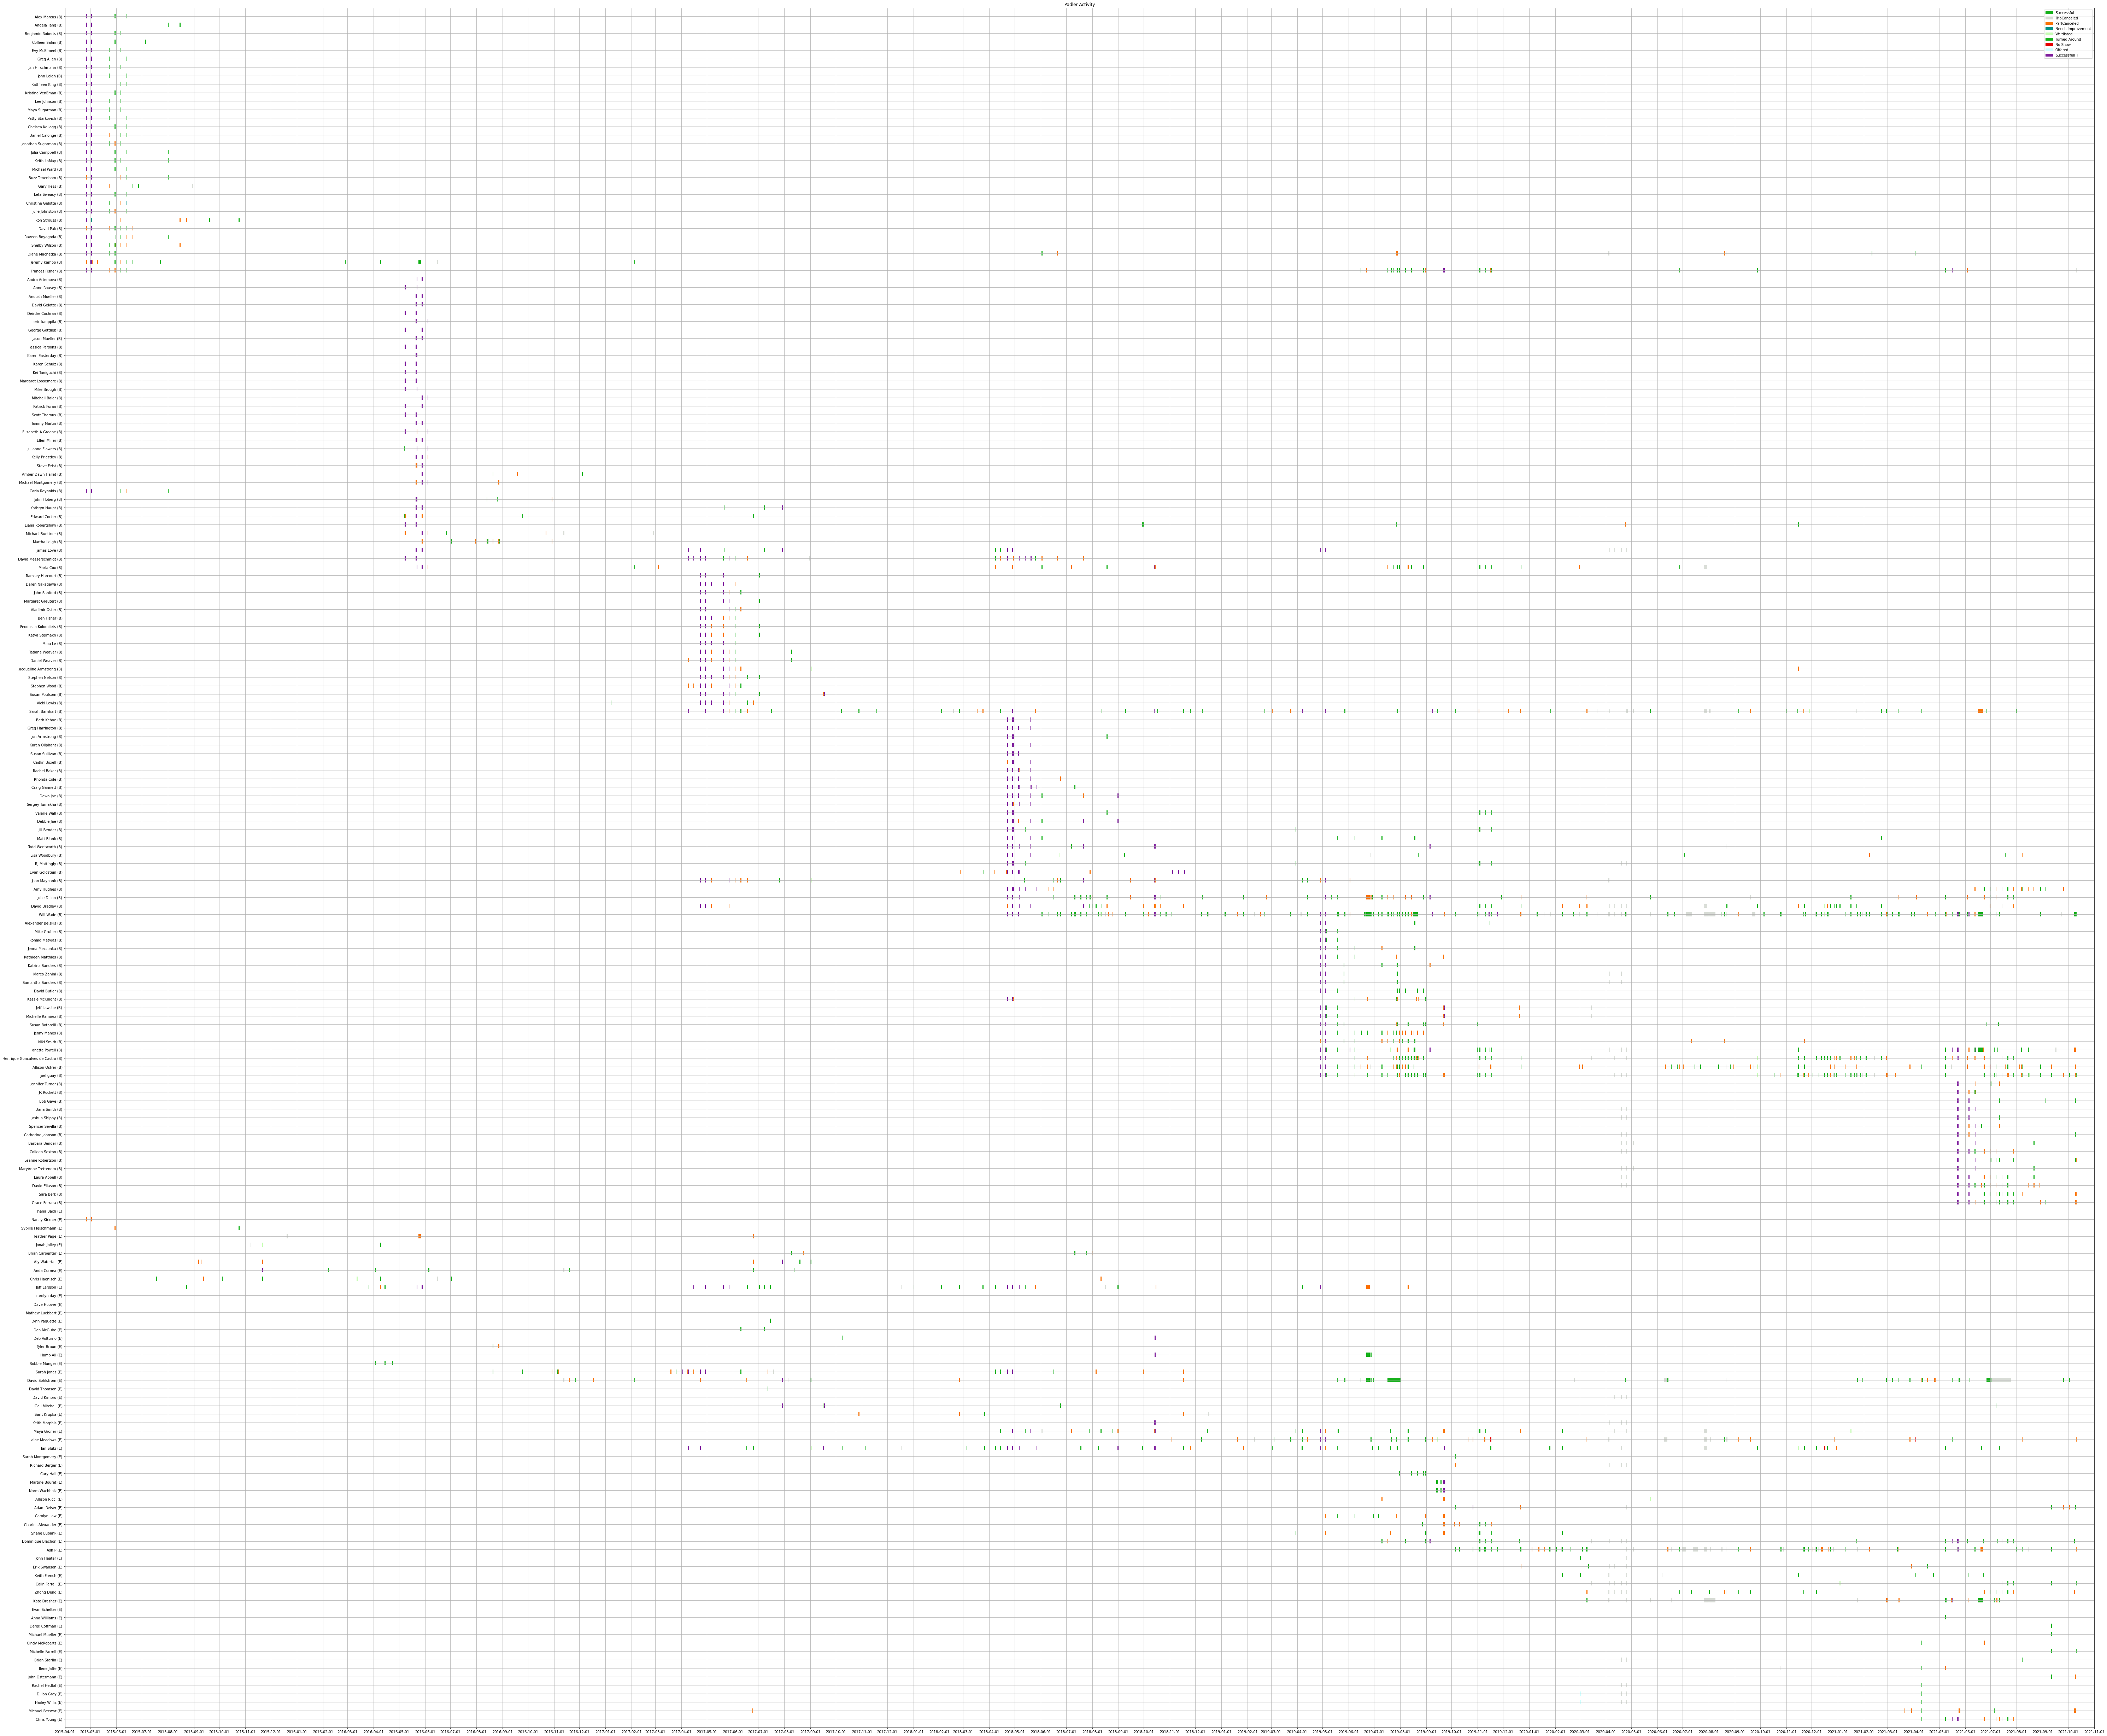

In [9]:
colormap = { 'Successful' : "xkcd:green", 			# Green is good
              'TripCanceled' : "xkcd:light grey", 	# Grey is missed opportunity
              'PartCanceled' : "xkcd:orange", 		# Orange is OK but too much is a problem
              'Needs Improvement': "xkcd:teal", 	# Not common
              'Waitlisted' : "xkcd:pale green",		# light green is a wish not fufulled
              'Turned Around' : "xkcd:green", 		# Not common.  A good try
              'No Show' : "xkcd:red", 				# Red is a problem.
              'Offered' : "xkcd:pale blue",			# Not common. 
			  "SuccessfulFT" : "xkcd:purple"		# Purple is also good, but different than a trip.
              }

def colorForTrip(trip: pd.Series):
	# Calculate the color.  
	# Does some work to distinguish between cancelled trip and paddler canceling from trip.
	pdResult = trip[C_ACTIVITYPARTICIPANTRESULT]
	if pdResult == "Canceled":
		pdResult = "TripCanceled" if trip[C_ACTIVITYRESULT] == "Canceled" else "PartCanceled"
	if pdResult =="Successful" and trip[C_ACTIVITYCATEGORY] == "Field trip":
		pdResult = "SuccessfulFT"
	return colormap[pdResult]




def plotActivity(roster: pd.DataFrame, activity: pd.DataFrame, title: str, fileName: str):
	ystep = 8
	barHeight = 2

	paddlerCount = len(roster)
	dateRange = mtnleaderreport.fullMonthRange(mtnleaderreport.pdtstodtdt(activity[C_ACTIVITYSTARTDATE].min()), 
												mtnleaderreport.pdtstodtdt(activity[C_ACTIVITYENDDATE].max()))
	days = (dateRange[1] - dateRange[0]).days
	paddlerLabels = []

	def paddlerYPos(number):
		p = ((paddlerCount - number) * ystep) - barHeight
		return p
	
	fig, ax = plt.subplots(figsize=(10+days/33, 1 + paddlerCount/3.0))

	paddlerNumber = 0
	for paddlerName, row in roster.iterrows():
		paddlerLabels.append(f"{paddlerName} ({row[C_PADDLERTYPE][:1]})")
		if paddlerName in activity.index:
			# Putting the single paddler name in a list ensures trips will always be a dataframe.  
			#  (Else, if there was only one trip, return would be a Series of that single row.)
			trips = activity.loc[[paddlerName]]
			trips = trips.sort_values(by=[C_ACTIVITYSTARTDATE])
			barList = []
			colorList = []
			for index, trip in trips.iterrows():
				dt = trip[C_ACTIVITYSTARTDATE] - trip[C_ACTIVITYENDDATE]
				days = dt.days + 1
				dt = datetime.timedelta(days=days)
				barList.append( ( trip[C_ACTIVITYSTARTDATE], dt ) )
				color = colorForTrip(trip)
				#print (f"{index} {trip[C_ACTIVITYSTARTDATE]} {trip[C_ACTIVITYRESULT]} {trip[C_ACTIVITYPARTICIPANTRESULT]} -> {color}")
				colorList.append(color)
			ax.broken_barh(barList, (paddlerYPos(paddlerNumber), barHeight*2), facecolors=colorList)
		paddlerNumber += 1
	
	ax.set_xlim(dateRange[0], dateRange[1])

	ax.set_ylim(0, (paddlerNumber+1) * ystep)

	# Vertial ticks are paddler names.  
	yticks = range(ystep, (paddlerNumber+1) * ystep, ystep)
	paddlerLabels.reverse()
	ax.set_yticks (yticks)
	ax.set_yticklabels (paddlerLabels)

	# Horizontal ticks are months
	xtickList = []
	xt = dateRange[0]
	while xt <= dateRange[1]:
		xtickList.append(xt)
		xt = xt + relativedelta(months=1)
	ax.set_xticks(xtickList)
	ax.set_title(title)
	ax.grid(True)

	# Legend comes from the color map.  
	# Setting number of columns to the size of color map makes it layout in one row at top of the plot.
	legendEntries = []
	for t in colormap.keys():
		legendEntries.append(mpatches.Patch(color=colormap[t], label=t))
	plt.legend(handles=legendEntries)#, ncol=len(colormap))

	fig.tight_layout()

	if fileName:
		print (f"Saving '{fileName}'")
		plt.savefig(fileName)



fullRoster.sort_values( by=[ C_PADDLERTYPE, C_GRADYEAR, C_TRIPCOUNT ], inplace=True)
plotActivity(fullRoster, fullActivity, "Padler Activity", "Paddler Activity.jpg")
